# GPT Fundamentals

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Understand what makes the "magic" of GPT and Large Language Models (LLMs) possible via foundational concepts of word embeddings and the transformer architecture.
* Get an intuition of word embeddings as numbers projected in vector space. 
* Distinguish components of the self-attention mechanism in transformer models.
* Adjust hyperparameters of GPT models to control output randomness. 
* Compare the output of different LLMs.
    
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
📝 **Poll:** A Zoom poll to check in with you.<br>

### Sections
1. [This Workshop](#this)
2. [History of GPT: Encoding Text](#hist)
3. [Transformer Architecture](#transf)
4. [Generating Text: Enter GPT](#gpt)
5. [Bonus: Comparing Models](#comp)

<a id='this'></a>

# This Workshop 

Most of us are using [ChatGPT](https://chat.openai.com) and other similar Generative AI tools on a daily basis. But how does it work? This workshop will explain foundational concepts from the recent developments in AI that make this technology work.

**📝 Poll 1**: How often do you use ChatGPT?

## Defining LLMs

A Large Language Model (LLM) is a type of Artificial Intelligence that processes and generates human-like text by **learning** from a vast dataset of existing writing. It predicts and assembles words in response to queries or prompts, mimicking the style and content it has been trained on.

In this workshop, we will look at GPT, a type of Large Language Model developed by OpenAI. It can generate human-like text, answer questions, summarize text, translate text to other languages, generate code, and more.

It is worth asking how it is able to have such a nuanced understanding of language--and what "understanding" means in this context of machine learning!

As we will see, the history of Large Language Models is a history of turning words into numbers in increasingly clever ways.

<a id='hist'></a>

# History of GPT: Encoding Text

<img src='../images/LM-history.png' alt="Language Modeling history" width="600" height="700">

## The Bag of Words model (1950s-2010s)

In order to appreciate how exciting it is to capture semantic content by numbers, you should know something about how words typically were encoded by computers before the early 2010s.

In order to have computers work with text, the text must be represented by numbers. In a **Bag of Words model**, a corpus of texts is transformed into a fixed-length vector (a list of numbers) whose length is the vocabulary of the whole corpus. Each position in the vector corresponds to a word in the vocabulary, and each value in the vector corresponds to the frequency of the word in a given document.

Let's have a look:

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

# Example documents
documents = [
    "the cat sat on the mat",
    "dogs are better than cats",
    "the dog chased the cat"
]

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the documents
bow_matrix = vectorizer.fit_transform(documents)

# Get feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert bow_matrix to an array and display the contents along with feature names
print("Vocabulary:\n", feature_names)
print("Bag of Words Matrix:\n", bow_matrix.toarray())


Vocabulary:
 ['are' 'better' 'cat' 'cats' 'chased' 'dog' 'dogs' 'mat' 'on' 'sat' 'than'
 'the']
Bag of Words Matrix:
 [[0 0 1 0 0 0 0 1 1 1 0 2]
 [1 1 0 1 0 0 1 0 0 0 1 0]
 [0 0 1 0 1 1 0 0 0 0 0 2]]


Note that a Bag of Words model treats each word occurrence independently, disregarding the context or order of words--hence the name.

This way of encoding text has issues. Image we had a large corpus of a million unique words--each word would have to be captured in a vector that is one million in length. Worse yet, most numbers in that vector would be 0! That doesn't sound like an ideal way to capture information. 

Just as importantly, what this method lacks is a representation of **semantic relationships** between words. We know where they exist in a text, and how often--but not *how they relate to each other*!

## Enter Word Embeddings (early 2010s)

> “You shall know a word by the company it keeps” (JR Firth 1957) 

The introduction of Word2Vec by a team at Google in 2013 marked a significant shift in the field. Word2Vec is a method to create **word embeddings**: that is, representing words in **vector spaces**. That means not a bunch of 0s and some word counts, like we just saw (e.g. `[0 0 1 0 0 0 0 1 1 1 0 2]`), but a series of complex values for every word (e.g. `[0.07380505, -0.01533471, -0.04536613,  0.06554051]`). 

Interestingly, these numbers (AKA **parameters** or **weights**) capture semantic meaning. This also means we can do interesting calculations with them, such as "word algebra":

`V(King) - V(man) + V(Woman) ~ V(Queen)`

### Training a Word Embeddings Model

The values of word embeddings are initiated randomly, but as the model is trained on data, these values eventually encode the meaning of words. 

In word embeddings, we treat semantic relations as a Machine Learning (ML) problem. Essentially, we teach a **neural network** how to predict the similarity of words by throwing in all of the words in our corpus, and training it to identify patterns and relationships between them based on their contextual usage.

This process involves looking at words that appear closely together within a sentence or document, and assume that this mean they have similar meanings. That's all! Surprisingly, this is enough to capture all kinds of semantic and syntactic features in the data.

In the famous words of linguist J.R. Firth: 
#### "You shall know a word by the company it keeps."

We will not cover the neural network or training process of Word2Vec here, but the point is that each word is represented by a **dense vector** of numbers. In simple terms: not a list with lots of 0's and some 1's, but a list full of complex numbers. 

<img src='../images/embedding.png' alt="Word embedding example" width="400">


The learning that goes on within the neural network is about nudging these word vectors (lists) so that they get better and better at *being predicted*.

Bottom line: Word embeddings models yield vectors that are both much shorter, and much more information-rich than Bag of Words models.

In [2]:
from gensim.models import Word2Vec

# Sample sentences
sentences = [
    ["the", "cat", "sat", "on", "the", "mat"],
    ["dogs", "are", "better", "than", "cats"],
    ["the", "dog", "chased", "the", "cat"]
]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=10, window=2, min_count=1, sg=1)

# Retrieve the vector for the word 'cat'
cat_vector = model.wv['cat']

print("Embedding for the word 'cat':\n", cat_vector)


Embedding for the word 'cat':
 [ 0.07380505 -0.01533471 -0.04536613  0.06554051 -0.0486016  -0.01816018
  0.0287658   0.00991874 -0.08285215 -0.09448818]


### Tokenization

Note that we offered our Word2Vec model a bunch of separate strings just now. Effectively, we were doing a crude from of **tokenization**: splitting up a sentence into its individual (uncapitalized) words.

Tokenization is a fundamental preprocessing step in the development of word embeddings. It acts as the bridge between raw text data and numerical models that can process and analyze language. 

Tokenization involves breaking down text into manageable, meaningful units--be they words, subwords, or characters. Often, it involves normalizing text by turning it into lower case, stemming or lemmatizing words, and removing stopwords (commonly used words, such as "a", "the", or "and").

There are many packages you can use in Python to tokenize a text. Here's one from NLTK:

In [3]:
import nltk
from nltk.tokenize import word_tokenize

# Downloading the Punkt tokenizer models for NLTK
#nltk.download('punkt')

# Example text
text = "The cat sat on the mat"

word_tokenize(text)

['The', 'cat', 'sat', 'on', 'the', 'mat']

### Visualizing Word Embeddings
 
Let's return to our word embeddings. The useful thing about these embeddings is that words (or really, tokens) with similar vectors have similar meanings. In fact, particular "directions" in the embedding space turn out to be associated with particular types of meaning. For instance, word embedding directions capture things like tenses, gender, or country-capital relations.

<img src='../images/vector.png' alt="word embeddings vectors" width="600">

You may be asking: how are we visualizing this? 

This is not straightforward. When we work with word embeddings, we are dealing with high-dimension space (in the code example above: 10 dimensions). This is impossible to visualize!

However, we can reduce these dimensions using algorithms such as Principle Comonent Analysis (PCA).

Using PCA, we will reduce the dimensionality of our 10-dimensional words to 2 dimensions, allowing us to visualize them in a 2-dimensional graph.

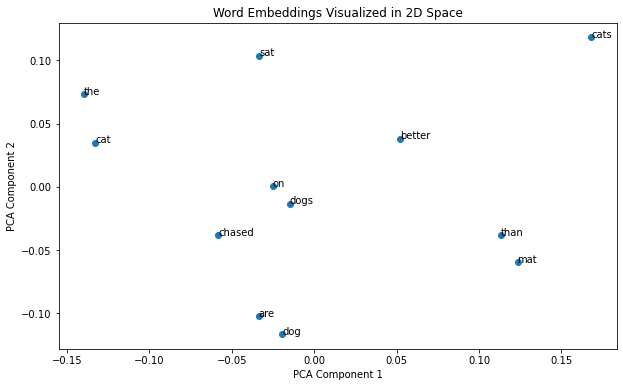

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Retrieve the vocabulary of the model
words = list(model.wv.index_to_key)

# Retrieve the embeddings of the words
embeddings = [model.wv[word] for word in words]

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
result = pca.fit_transform(embeddings)

# Create a scatter plot of the projection
plt.figure(figsize=(10, 6))
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.title('Word Embeddings Visualized in 2D Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


🔔 **Question**: Note that this model was only trained on three sentences:

    "the cat sat on the mat"
    "dogs are better than cats"
    "the dog chased the cat"
    
Given what you know about how word embeddings work, can you see why the embeddings are clustering the way they are?

### Word Embeddings in Action

Let's now download an existing word embeddings model called [GloVe](https://nlp.stanford.edu/projects/glove/) (2014) which was **pre-trained** based on 2 billion tweets. This model has a vocabulary of 1.2 million words (instead of the 12 words we trained our little model on above). 

Let's look up the vectors for some words of our choice that we assume might be related, like "king", "queen", "man", and "woman".

Feel free to play around with the words in `words` to see where they end up in the visualization!

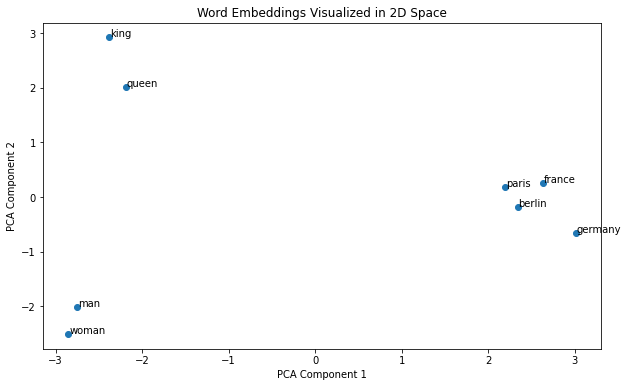

In [5]:
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Download a word embedding model
model = api.load("glove-wiki-gigaword-50")

# Select words you're interested in
words = ["king", "queen", "man", "woman", "paris", "berlin", "france", "germany"]

# Get corresponding vectors
word_vectors = [model[word] for word in words]

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

# Create a scatter plot of the projection
plt.figure(figsize=(10, 6))
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0]+0.01, result[i, 1]+0.01))

plt.title('Word Embeddings Visualized in 2D Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### Comparing Embeddings

Without getting too deep into the math behind this, one helpful intuition is that the **dot product** of two vectors can be thought of as a measure of how well they align. 

Geometrically, the dot product is positive when vectors point in similar diections, and negative if they don't.

We can make use of this intuition to see if an embedding model captures particular semantic differences. For instance, let's import `glove`, and calculate the difference between the vectors for the words "cats" and "cat". The idea is we should get a vector that captures plurality. We can then compare this vector to other words in singular or plural to check whether they are positive or negative.

In [6]:
import gensim.downloader as api
from scipy.spatial.distance import cosine

# Calculate the "plurality" vector - like asking "what differentiates "cats" from "cat"?
plurality_vector = model['cats'] - model['cat']

# Now, let's define some example singular and plural nouns for comparison
singular_nouns = ['dog', 'house', 'car']
plural_nouns = ['dogs', 'houses', 'cars']

# Function to compute the cosine similarity (as dot product)
# Note: Word2Vec embeddings are usually normalized, so dot product gives cosine similarity
def compare_similarity(reference_vector, comparison_words):
    similarities = {}
    for word in comparison_words:
        # Compute cosine similarity
        similarity = 1 - cosine(reference_vector, model[word])
        similarities[word] = similarity
    return similarities

# Compare the "plurality" vector against singular and plural nouns
singular_similarities = compare_similarity(plurality_vector, singular_nouns)
plural_similarities = compare_similarity(plurality_vector, plural_nouns)

Let's visualize:

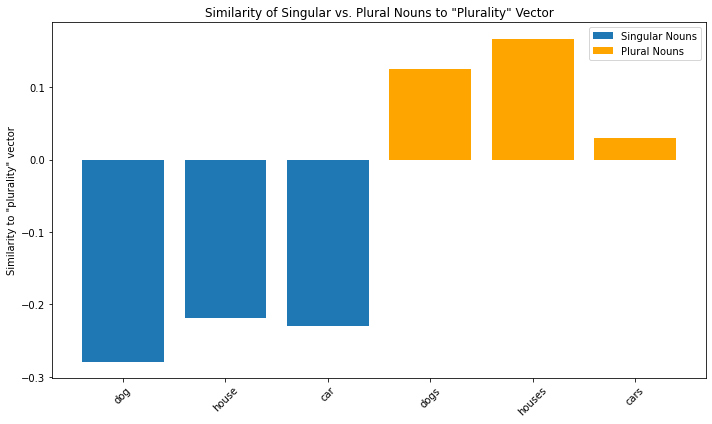

In [7]:
import matplotlib.pyplot as plt

# Assuming `singular_similarities` and `plural_similarities` are your computed dictionaries
# Example structure: {'dog': 0.8, 'house': 0.75}

# Data preparation for plotting
labels = list(singular_similarities.keys()) + list(plural_similarities.keys())
singular_scores = list(singular_similarities.values())
plural_scores = list(plural_similarities.values())

# Indices for singular and plural nouns on the x-axis
x_singular = range(len(singular_similarities))
x_plural = range(len(singular_similarities), len(singular_similarities) + len(plural_similarities))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x_singular, singular_scores, label='Singular Nouns')
plt.bar(x_plural, plural_scores, label='Plural Nouns', color='orange')

# Adding labels and title
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylabel('Similarity to "plurality" vector')
plt.title('Similarity of Singular vs. Plural Nouns to "Plurality" Vector')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Looks like the plural words do align more with the direction of our "plurality" vector!

🔔 **Question:** Can you think of another certain dimension of meaning that might be encoded across the vector space of the embeddings? For instance, what would happen when we compute `model['king'] - model['queen']`?

### So.. that seems great!

Word embeddings capture a lot more information than Bag of Words models. But there was still information that was not being captured. 

For instance, while word embeddings capture word-level relationships, they don't inherently account for **word order** or word ambiguity. The challenge became to handle **sequence data**. 

🔔 **Question**: What is a word embedding? Can we have video or image embeddings, and if so, what would those embeddings capture?

<a id='transf'></a>
# Transformer Architecture

The Transformer architecture, introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017, addresses the issue of long-term dependencies that can be challenging for the networks that came before. 

Where traditional word embedding vectors are static--each word type has one vector associated with it--the transformer architecture allows us to create more dynamic vectors that are created by taking into account the surrounding tokens of some target token. More on this in a bit!

For now, note that this is useful because words have different meanings based on the context they are in. Think of the word "model" (as in "language model" versus "fasion model".) Transformers help to disambiguate these two words.

## Encoders and Decoders

There are a few 'flavors' of the Transformer architecture, meant for different purposes.

| Type | Example | Model |
| -----| ------- | ----- |
| Sequence to fixed | E-mail classification | Encoder |
| Fixed to sequence | Image description | Decoder | 
| Sequence to sequence | Translation | Encoder-Decoder |

The original Transformer architecture was initially designed primarily for the task of **machine translation**, making use of the encoder-decoder model.

So how do these components work?

- **Encoder**: Processes the input data (like a sentence in a text). It analyzes and understands the context and relationships between words or tokens in the input. It transforms the input into an intermediate representation that captures this information.

- **Decoder**: Takes the intermediate representation from the encoder and generates output data (like the translated text in another language).

<img src='../images/bert-GPT.webp' alt="Architecture of GPT vs BERT" width="600" height="700">

Vaswani et al's paper stacks 6 encoders/decoders on top of each other. This is not a magic number; it's just a hyperparameter. 

### Context Size

The **context size** of a model, also known as the maximum sequence length, is an important parameter that determines how many tokens (words or subwords) a model can process at once in a single input. This limit is crucial because it defines the maximum extent of context that the model can consider for tasks such as sentence prediction, question answering, and other language understanding tasks.

Note that the context size in a model is equal to amount of vectors/embeddings in the model. For instance, BERT's context size is 512 tokens, and GPT2's is 1024 tokens. This also impacts learning! For instance, you would need to truncate a longer paragraph to 512 tokens when training BERT).

## Enter BERT

Released in 2018 by researchers at Google, BERT (Bidirectional Encoder Representations from Transformers) is an early LLM built on the transformer architecture, and was trained on the entirity of Wikipedia and [BookCorpus](https://en.wikipedia.org/wiki/BookCorpus) from 7000 unpublished books of various genres. These two sources include 3.3 Billion words in total.

BERT, like other LLMs, makes use of machine learning to learn about language. This means it is not explicitly defining procedures for how to behave (like AI engineers used to do in the early days of AI) but set up flexible structure with tunable **parameters** (think of a bunch of knobs and dials), and using many examples of what the output should look like given an input.

A simple example of Machine Learning is linear regression. Here, you have 2 parameters: a slope and a y-intercept. Together, these can yield a line of best fit to match some data points and create predictions.

<img src='../images/lr.png' alt="Language Modeling history" width="500">

To compare: One of the two initial releases of BERT, [BERT-base](https://huggingface.co/bert-base-uncased), includes around **110 million parameters**. These parameters, in a neural network context, are the weights of the model that are learned from the training data, and they determine how the model behaves. 

### BERT is a Foundation Model

BERT is a so-called **foundation model**: a model that is trained on broad data, so that it can be applied across a wide range of use cases and downstream tasks like question answering, natural language inference, and other language tasks. 

This means it just needs to encode the language representations so that it could be used for other tasks. For instance, it was used in powering [Google Search](https://blog.google/products/search/search-language-understanding-bert/). 

Because of this, BERT is an "encoder-only" model. Individual researchers could add a decoder while doing specific tasks; this decoder could be anything based on your task.

## Encoders and Decoders: Self-Attention and Feedforward

Let's talk a bit more about encoders and decoders. They can be further broken down in 2 sublayers: the **self-attention** and **feedforward** layer. They work slightly differenty in encoders and decoders, but we will simplify things a bit and just talk about the general idea behind these two components during training.

<img src='../images/bert-GPT.webp' alt="Architecture of GPT vs BERT" width="600" height="700">

### Positional Embeddings

In the first step of a Transformer model, the tokens of a corpus are turned into an **embedding matrix**--just like in Word2Vec. 

First, input text is tokenized. These token embeddings are then typically added onto **positional embeddings** which incorporate information about the position of each token in the sequence.

<img src='../images/pos-emb.png' alt="Positional embeddings added to token embeddings" width="400">

These tokens are then mapped to vectors (a list of numbers) using the embedding layer. If the model is being trained from scratch, these initial embeddings start with random weights. But unlike in Word2Vec, the weights of these transformer embeddings are updated based on the **self-attention mechanisms** and **feedforward layers** in the model.

### Self-Attention

Self-attention uses so-called **attention heads**, which you can think of as mechanisms that produce yet more vectors. Their goal is to refine the initial embeddings by capturing information from contextual tokens.

The self-attention layer in the encoder considers each word it processes in the context of every other word in the same sentence, regardless of their position or distance from each other. This is achieved by enabling every part of the sentence to "attend to" or focus on, all other parts simultaneously. As a result, this mechanism captures the dependencies and relationships between words, ensuring that even words far apart in a sentence can influence the overall understanding of the text. 

<img src='../images/embedding-attention.png' alt="Word embeddings with attention" width="400">

This effectively allows us to consider the **context** in which a word is used. After all, the usage of words changes based on their context. For instance, the word "bank" in "river bank" and in "bank robber" mean different things, and require different vector representations. This was impossible before attention mechanisms came along.

In other words: a well-trained attention head calculates what you need to add to the generic embedding in order to move it into a more specific direction, so that "bank" in "bank robber" has a different direction than "bank" in "river bank".

<img src='../images/vec-disambiguation.png' alt="Disambiguating words" width="400">

A transformer typically has many attention heads working simultaneously--early models used 12 attention heads per layer. The intuition behind having multiple attention heads is that one head might focus on the syntactic relationship between words in a sentence, while another might capture semantic relationships.

Take an (oversimplified) example: one attention head might be looking at nouns that ingest the meaning of corresponding adjectives in the sentence "the fluffy pink cloud". The head will look at tokens before the word "cloud" to check whether there are adjectives preceding it. If so, it will help update the embedding for this word "cloud" to include information about these prior words.

### Feedforward Layer

The **feedforward layer** in the encoder is a neural network that applies a combination of linear and nonlinear transformations to the output of the previous layer. This is done identically and independently for each position in the sequence. The purpose of this layer is to transform the processed information in a way that captures more complex patterns and relationships.

Note that the feedforward layer introduces non-linearity into the model. Without them, the transformer would consist only of attention layers, which are essentially linear operations (a series of dot products and softmax functions). 

### Parallelization

One of the big advantages of Transformers over previous models (such as RNNs and LSTMs) is that they process the entire input sequence at once. This lack of sequential dependency means that the model can process all elements of the input in parallel during training, which dramatically increases computational efficiency.

Not that "parallel" doesn't mean each calculation is isolated; rather, each calculation (while independent in terms of execution) can access and incorporate information from all other calculations. The attention scores between elements in the sequence are calculated using matrix multiplications, which are highly optimized for parallel computation, especially on modern hardware like GPUs or TPUs.

### Calculating Loss 

How does a transformer model actually learn?

At the end of the Feedforward layer, the model's predictions (also called logits) are compared with the actual next tokens in the input sequence. A common choice for this task is **cross-entropy loss**, which measures how well the predicted probability distribution matches the actual distribution (the true next tokens).

After calculating the loss, gradients of this loss with respect to all the model weights (i.e., the embedding vectors, attention block vectors, feedforward vectors, and any other learnable parameters in the model) are computed using **backpropagation**. This involves applying the chain rule of calculus to find out how changes in each weight would affect the loss, working backward from the output layer to the initial embedding layer.

With the gradients computed, the model's weights are updated to minimize the loss.

🔔 **Question**: How do the terms 'attention' and 'context' mean when it comes to transformer architecture? How do we distinguish between how those words are used to refer to human capacities?

## Visualizing Self-Attention using BertViz

In order to get a better sense of the attention mechanism, we can use a package called BertViz. It offers several ways to visualize the process.

In [8]:
# Uncomment this cell if you need to install
#%pip install bertviz transformers

In [9]:
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification, utils

utils.logging.set_verbosity_error()  # Suppress standard warnings

# Model and tokenizer initialization
model_version = 'bert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_version, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)

# Single sentence for processing
sentence = "The bank will not accept the deposit because it is full."

# Tokenization and encoding the sentence
inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]  # Get the attention tensors from the model

# Convert input IDs to token list for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

### Model View

This view shows how each attention head, in each layer, is focusing on different parts of the input sentence. **Click on the different heads to see the words and attention graph.**

This focus is represented by lines or colors connecting different words or tokens, indicating where the model is 'paying attention' when processing each word.

In simple terms, you're looking at what each part of the model considers important (or relevant) when interpreting a word in the context of the entire sentence.

In [10]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

Note the `[CLS]` token, which is used as an aggregate representation of the entire input sequence for classification tasks. 

<a id='gpt'></a>

# Generating Text: Enter GPT

The great thing about Transformers is that they can be used for different purposes. While BERT is an encoder-only model, companies such as OpenAI began leveraging the Transformer architecture for a large-scale generative system.

[GPT-1](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer#Foundational_models) was introduced around the same time as BERT, in 2018. OpenAI published an article entitled ["Improving Language Understanding by Generative Pre-Training"](https://openai.com/research/language-unsupervised) in which it introduced the first generative pre-trained transformer (GPT) system ("GPT-1"). GPT-1 was trained on [BookCorpus](https://en.wikipedia.org/wiki/BookCorpus) and has 117 million parameters.

GPT models are based on the decoder part of the original Transformer architecture. Unlike the full Transformer model that has both encoder and decoder components (used for tasks like translation), GPT only uses the decoder stack.

<img src='../images/bert-GPT.webp' alt="Architecture of GPT vs BERT" width="600" height="700">

Why is that? GPT's primary function is to generate text sequentially, predicting the next word based on the previous words. This is a task well-suited to the decoder component of the Transformer, which is inherently designed to generate sequences.

### Context Size, Revisited

Recall that the context size of a model determines how many tokens a model can process at once in a single input. The context size of GPT has rapidly increased:

| Model | Context Size |
| ----- | ------------ |
| GPT-2 | 1024 tokens |
| GPT-3 | 2048 - 4096 tokens |
| GPT-4 | 8,000 - 128,000 tokens |

### Next Token Prediction

Note that that GPT's decision about which token comes next is based completely on the **last encoded token** in the sequence! The intuition behind this is that this token embedding will have captured all the relevant information from the tokens before it.

The transformer output for the last token's position is transformed into a logits vector. These are raw prediction scores for each possible token in the model’s vocabulary. The logits are passed through a **softmax layer** to convert them into probabilities. The softmax function accentuates the highest logit, making it significantly higher in probability than the others. The token corresponding to the highest probability is chosen as the next token.

Bigger models like GPT-4 Turbo use caching mechanisms to manage its large context window efficiently. This would involve maintaining relevant hidden states across more tokens while minimizing computational overhead.

### Unidirectional Modeling

Note that in the **self-attention mechanism** in GPT, each token can only attend to previous tokens in the sequence. This is known as causal or unidirectional language modeling, suitable for generating text. During training, we do not want the model to be able to "cheat" by looking at what tokens will be coming next. After all, during inference, it won't have access to these future tokens. 

<img src='../images/unidirectional.png' alt="Unidirectional language modeling" width="600" height="700">

During text generation, the model generates one token at a time, and for each new token, it recalculates the attention using all the tokens generated so far, including the new one.

This means that GPT does not see "prompts" and "responses" like we do. It simply predicts the next token based on the input prompt, and **adds its own tokens to that input prompt at each step.**

<img src='../images/GPT_sees.png' alt="What GPT sees vs. What you see" width="700">

## Tokenization

We haven't really covered tokenization yet, but it is at the heart of a lot of weirdness about LLMs:

- Why can’t LLMs spell words? Tokenization!
- Why is LLM bad at simple arithmetic? Tokenization!
- Why does LLM perform worse at other languages? Tokenization!

To see how this works, let's check out **Tiktokenizer**. This is a tool for developers to track users' token usage. We can use it to see how text is transformed into tokens by different LLMs!

Let's go to [Tiktokenizer](https://tiktokenizer.vercel.app/?encoder=gpt2) for GPT2 and enter the folowing example prompt:

In [11]:
# Tokenization causes many weird issues! It's worth thinking about.

# Tokenization zorgt voor veel gekke problemen! Het is de moeite waard om erover na te denken.

127 + 677 == 804
1275 + 6773 == 8041

for i in range(3):
	if i == 0:
		print("I am zero")
	elif i == 1:
		print("I am positive")
	else:
		print("I am greater than 1")

I am zero
I am positive
I am greater than 1


Next, let's change tokenizer to `cl100k_base`: this is the GPT4 tokenizer. Note how this reduces the amount of tokens needed for this prompt. This is because the model has more tokens to choose from (about double!) 


Note: GPT models generally use **subword tokenization** methods like Byte-Pair Encoding (BPE). This involves determining the vocabulary of subwords based on frequency statistics of pairs of characters/subwords in the training corpus. Once "trained", the tokenizer has a fixed vocabulary. This vocabulary is used to encode any text into token IDs that GPT's layers can process.

## Training GPT

Like BERT, OpenAI's GPT models (such as GPT-2 and GPT-4) are so-called **foundation models**: models that are trained on broad data such that they can be applied across a wide range of use cases. 

Training involves two training stages: pre-training and fine-tuning.

#### Pre-training
Initially, the GPT model is exposed to a massive, diverse dataset. This dataset isn't specifically tailored to any particular task, but encompasses a broad range of general language data. 

This process is done through **Autoregressive Modeling**. In this method, the model is trained to predict the next word in a sentence given all the previous words. It learns to generate text by sequentially predicting one word at a time, using the context of all the preceding words in the sequence.

#### Fine-tuning
After pre-training, GPT is fine-tuned on specific tasks (like question answering, text generation, etc.) using supervised learning. This involves training on a smaller, task-specific dataset, often using human labeling.

## Using GPT to generate text

With all of that out of the way, let's use GPT-2 to generate some text based on an input text. Here's what we do:

- `tokenizer(prompt, return_tensors='pt')`: We use the tokenizer to convert the prompt text into a format that the model can understand. The tokenizer performs several steps, including splitting the text into tokens (words or subwords), converting these tokens into numerical IDs (tokenization), and preparing these token IDs in a tensor format suitable for PyTorch `(return_tensors='pt')`.

- `.input_ids`: This extracts just the input IDs from the tokenized output. These IDs are what the model actually processes to generate predictions.


In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

prompt = 'it was a dark and stormy night'     

# generate the result with contrastive search
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids

tensor([[ 270,  373,  257, 3223,  290, 6388,   88, 1755]])

Next, we set some hyperparameters such as `temperature` and `top_k`. More on what these mean later!

We then call `model.generate(...)`: it tells the model to generate text based on the provided input_ids.

In [13]:
temperature = 0.9   # a higher temperature will produce more diverse results, but with a higher risk of less coherent text
top_k = 8           # the number of tokens to sample from at each step
max_length = 80     # the maximum number of tokens for the output of the model

output = model.generate(input_ids, do_sample=True, temperature=temperature, top_k=top_k, max_length=max_length)
output

tensor([[ 270,  373,  257, 3223,  290, 6388,   88, 1755,   11,  290,  340,  373,
          523, 3223,   13,  383, 1657,  373, 3223,   11,  262, 8824,  373, 3223,
           11,  262, 8824,  373, 3223,   11,  262, 8824,  373, 3223,   11,  262,
         8824,  373, 3223,   11,  262, 8824,  373, 3223,   11,  262, 8824,  373,
         3223,   11,  262, 8824,  373, 3223,   11,  262, 8824,  373, 3223,   11,
          262, 8824,  373, 3223,   11,  262, 8824,  373, 3223,   11,  262, 8824,
          373, 3223,   11,  262, 8824,  373, 3223,   11]])

Finally, we call `tokenizer.decode(...)`: it tells the model to decode the sequence of numbers into words.

In [14]:
# we use a loop since model.generate  can produce multiple sequences of text when the num_return_sequences parameter 
# is set to a value greater than 1

for i, sequence in enumerate(output):
    decoded_sequence = tokenizer.decode(sequence, skip_special_tokens=True)
    print(f"Generated text {i+1}:")
    print(decoded_sequence)
    print("\n")

Generated text 1:
it was a dark and stormy night, and it was so dark. The light was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark, the moon was dark,




💡 **Tip**:  Play around with the hyperparameters above to see how it changes the output!

## Generating Multiple Outputs

Because text generation using GPT is a stochastic process, we will get different results each time we run it. Here, we will run the same operation 5 times so we can see the variation in the output.

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")
prompt = 'it was a dark and stormy night'
temperature = 0.9
top_k = 8
max_length = 80
repetition_penalty = 1
num_return_sequences = 5
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(input_ids,
                        do_sample=True,
                        temperature=temperature,
                        top_k=top_k,
                        max_length=max_length,
                        num_return_sequences=num_return_sequences,
                        repetition_penalty=repetition_penalty,
                        penalty_alpha=0.6,
                        no_repeat_ngram_size=1,
                        early_stopping=True)
# Decoding the output to text
for i in range(num_return_sequences):
    print(f"Generated text {i+1}:")
    print(tokenizer.decode(output[i], skip_special_tokens=True))
    print("\n")

/Users/tomvannuenen/anaconda3/envs/dlab/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated text 1:
it was a dark and stormy night, as though I had never seen an enemy so strong in the face of darkness. But there were no signs that he did not have it all together or with him."
"He said to me: 'If you can't help us find one man who is more dangerous than my son - if your brother's name comes from this town where his wife lives


Generated text 2:
it was a dark and stormy night, but he never let it go.


Generated text 3:
it was a dark and stormy night.
“It wasn't just that I had to go out of my way for this, but it felt like there's something in the world about being so beautiful...I couldn't believe how many people were looking at me....but they knew what their lives would be after them! It seemed as though all hell went on here."


Generated text 4:
it was a dark and stormy night. It wasn't like that; it didn´t have its own atmosphere, but with all the noise coming from around here."
The next day he saw two more people in an ambulance on one side of his bed who wer

## Controlling the Randomness

As we have seen, the process of word generation inherently includes randomness. The question, then, is how we can control that randomness. GPT2 has several parameters to do so.

Temperature: The `temperature` parameter is used to control the randomness in the probability distribution of the next word predictions. A low temperature (close to 0) makes the model more confident in its top choices (more deterministic), leading to less random and more predictable text. As the temperature increases, the model's predictions become more random and diverse. Essentially, temperature "flattens" or "sharpens" the probability distribution. A high temperature gives lower-probability words more chance of being chosen, while a low temperature makes the model strongly favor high-probability words.

<img src='../images/temp.png' alt="Temperature in GPT" width="500">


Top-K Sampling (top_k): `top_k sampling` limits the model's next-word predictions to the top k most likely words. Only the k most probable next words are considered for each step in the generation process. This can help to focus the generation on more likely words and avoid the model going off on a tangent with less probable, irrelevant words. However, `top_k` sampling does not consider the cumulative probability of the words, so even very low-probability words might be included if they are among the top k.

Nucleus Sampling (top_p): `top_p sampling`, also known as nucleus sampling, considers the cumulative probability of the words.
It selects the smallest set of words whose cumulative probability exceeds the threshold p. This means it dynamically adjusts the number of words it considers based on their probability distribution. `top_p` provides a more dynamic approach compared to `top_k` as it can include more or fewer words depending on their probability distribution for each prediction.

In [16]:
from transformers import pipeline

text_generator = pipeline("text-generation", model="gpt2")

prompt = "Life on Mars could"
params = [
    {"temperature": 0.7, "top_p": 0.8, "top_k": 40},
    {"temperature": 0.9, "top_p": 0.9, "top_k": 80},
    {"temperature": 1.1, "top_p": 0.95, "top_k": 120}
]

for param in params:
    output = text_generator(prompt, max_length=50, temperature=param['temperature'], top_p=param['top_p'], top_k=param['top_k'])[0]['generated_text']
    print(f"Output with temperature = {param['temperature']}, top_p = {param['top_p']}, and top_k = {param['top_k']}:\n{output}\n")


Output with temperature = 0.7, top_p = 0.8, and top_k = 40:
Life on Mars could be a game changer for the space program.

The first stage of the mission, known as the "Mars 2020 mission," is expected to take place in 2020.

The first stage will use a robotic arm to

Output with temperature = 0.9, top_p = 0.9, and top_k = 80:
Life on Mars could provide significant amounts of science fiction and fantasy. The story begins in the 1950s, when the world's first Mars mission was launched. The mission, called "Mars Odyssey," took on NASA's first, and only, human presence

Output with temperature = 1.1, top_p = 0.95, and top_k = 120:
Life on Mars could be the biggest scientific problem of our time," said Kevin D. Greenblatt, a scientist at NASA. NASA scientists plan to launch a robotic probe to get an audience with the Curiosity rover as early as April 26. The science



### 💡 Tip: Value Ranges for Temperature, Top-K Sampling and Nucleus Sampling

#### Temperature:

**Minimum Value**: Technically, the temperature can be set to a value greater than 0. A value of 0 is not practical, as it would lead to division by zero in the softmax calculation. Practically, values close to 0 (e.g., 0.1) are used to make the model very confident, leading to repetitive and predictable text.

**Maximum Value**: There is no fixed upper limit for temperature, but extremely high values (e.g., above 2 or 3) make the model's output extremely random and incoherent. Commonly, values are kept between 0.7 and 1.5 for reasonable variation in text generation.

#### Top-K Sampling (top_k):

**Minimum Value**: The minimum value is 0, which effectively turns off top-k sampling. This means all words are considered, regardless of their probability.

**Maximum Value**: The maximum value is theoretically the size of the model's vocabulary. For GPT-2, this is around 50,000. Setting top_k to a very high value is equivalent to not using top-k sampling at all.

#### Nucleus Sampling (top_p):

**Minimum Value**: The minimum is 0, which would mean no words are selected, leading to no generation. In practice, a very low value (close to 0) would lead to extremely conservative text generation, with little to no variation.

**Maximum Value**: The maximum is 1, which means all words summing up to 100% of the probability distribution are considered. Setting top_p to 1 effectively turns off nucleus sampling, as the entire probability distribution is used.


🔔 **Question**: What does changing these values do to the outputs? How reliable and consistent are the results, and what does that mean for the field or application you envision using GPT in?
    

<div class="alert alert-success">

## ❗ Key Points

* The history of LLMs is a history of turning words into numbers in increasingly clever ways.
* "Vectorizing" words simply means to turn them into lists of numbers. The simplest way to do this is to count all unique words (terms) in a text, and encode their frequency.
* Traditional approaches use Bag of Words models, which do not account for word order / sequence.
* Word embeddings turn words into vectors that capture semantic content, but without looking at contextual relationships between words in a sentence. In other words, they are static.
* Transformer models turn words into dynamic vectors that capture semantic content, as well as contexual information that reflect varied meanings based on surrounding words.
</div>